In [2]:
import numpy as np
import scipy as sp
import scipy.stats
import itertools
import logging
import matplotlib.pyplot as plt
import pandas as pd
import torch.utils.data as utils
import math
import time
import tqdm

import torch
import torch.optim as optim
import torch.nn.functional as F
from argparse import ArgumentParser
from torch.distributions import MultivariateNormal

import torch.nn as nn
import torch.nn.init as init
import sys

sys.path.append("../new_flows")
from flows import RealNVP, Planar, MAF
from models import NormalizingFlowModel

## Load and process the data

In [3]:
df_purebkg = pd.read_hdf("/data/t3home000/spark/LHCOlympics_previous/preprocessed_40part_testdataset.h5")

In [4]:
dt = df_purebkg.values

In [5]:
idx = dt[:,120]
bkg_idx = np.where(idx==0)[0]
signal_idx = np.where(idx==1)[0]

In [6]:
dtsig = dt[signal_idx]

In [7]:
Ysig = dtsig[:,0:120]

In [8]:
dt = dt[bkg_idx]

In [9]:
dt.shape

(1000000, 121)

In [10]:
Y = dt[:,0:120]

In [11]:
Y.shape

(1000000, 120)

In [12]:
Ysig.shape

(100000, 120)

In [13]:
bkg_mean = []
bkg_std = []

In [14]:
for i in range(120):
    mean = np.mean(Y[:,i])
    std = np.std(Y[:,i])
    bkg_mean.append(mean)
    bkg_std.append(std)
    Y[:,i] = (Y[:,i]-mean)/std

In [15]:
for i in range(120):
    Ysig[:,i] = (Ysig[:,i]-bkg_mean[i])/bkg_std[i]

In [16]:
bkg_mean

[0.15568354823835454,
 -0.0005867081735644271,
 -0.0002195494067867985,
 0.09352003419875753,
 0.0008066970680608648,
 0.0002240764406314529,
 0.06587074638005737,
 0.0006636528594647327,
 -0.0023816153997407064,
 0.05084215107073321,
 -0.0003433368214237651,
 0.003544739682076891,
 0.041194707607967174,
 0.0012153682287392854,
 -0.0017556880113168882,
 0.03445028323526803,
 0.00015621156054875462,
 0.0011303441138484581,
 0.029433130023168087,
 0.00033110066620853433,
 0.0014597629791734247,
 0.025554713558371998,
 0.0015666148974230617,
 0.003421664592406814,
 0.022458324186554395,
 -0.0001844127132437102,
 0.0002240226817079931,
 0.019942695187274435,
 0.0004936437399459663,
 0.0015583877689536985,
 0.01786221155144192,
 0.0010821502362828215,
 -0.0008844580725029073,
 0.016117736009398826,
 0.0008851299893164844,
 0.0015120258585988831,
 0.014640304732674931,
 0.0018745958309205261,
 0.002447262887436696,
 0.013376902370589562,
 0.00019575080019466567,
 0.0038654146200466726,
 0.01

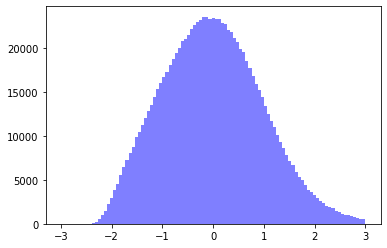

In [17]:
bins = np.linspace(-3,3,100)
bins.shape
column = 90
#print(f_rnd.columns[column])
#plt.ylim(0, 500)
plt.hist(Y[:,column],bins,alpha=0.5,color='b');
#plt.hist(sigout[:,column],bins,alpha=0.5,color='r');
#plt.hist(out2[:,column],bins,alpha=0.5,color='g');
#plt.axvline(np.mean(Y[:,column]))

In [18]:
bkg_mean

[0.15568354823835454,
 -0.0005867081735644271,
 -0.0002195494067867985,
 0.09352003419875753,
 0.0008066970680608648,
 0.0002240764406314529,
 0.06587074638005737,
 0.0006636528594647327,
 -0.0023816153997407064,
 0.05084215107073321,
 -0.0003433368214237651,
 0.003544739682076891,
 0.041194707607967174,
 0.0012153682287392854,
 -0.0017556880113168882,
 0.03445028323526803,
 0.00015621156054875462,
 0.0011303441138484581,
 0.029433130023168087,
 0.00033110066620853433,
 0.0014597629791734247,
 0.025554713558371998,
 0.0015666148974230617,
 0.003421664592406814,
 0.022458324186554395,
 -0.0001844127132437102,
 0.0002240226817079931,
 0.019942695187274435,
 0.0004936437399459663,
 0.0015583877689536985,
 0.01786221155144192,
 0.0010821502362828215,
 -0.0008844580725029073,
 0.016117736009398826,
 0.0008851299893164844,
 0.0015120258585988831,
 0.014640304732674931,
 0.0018745958309205261,
 0.002447262887436696,
 0.013376902370589562,
 0.00019575080019466567,
 0.0038654146200466726,
 0.01

In [19]:
bkg_std

[0.0713956292677596,
 0.7507873182311863,
 1.8138234336441186,
 0.04068548989709993,
 0.9003047706425654,
 2.4818206040266775,
 0.02510376862481816,
 0.8861255917398426,
 2.436271310723864,
 0.017828830840850386,
 0.8857666865536159,
 2.4279106636336656,
 0.013509871629879312,
 0.8909878643858806,
 2.437092954815987,
 0.010807285073102166,
 0.8980957591541436,
 2.44429170642392,
 0.008965877097261408,
 0.9065008955087697,
 2.4540057851271957,
 0.0076674348029005385,
 0.913037681322888,
 2.461993952157827,
 0.006694968344043351,
 0.9222931592544924,
 2.4713597294980634,
 0.005949591070161752,
 0.9287618339833602,
 2.4769508946609613,
 0.00536928474660857,
 0.9353571181236443,
 2.482387838543594,
 0.004898118017115649,
 0.942811390610076,
 2.4869531836469614,
 0.004510701384573931,
 0.9511756496924262,
 2.4914811584558936,
 0.004192540874146885,
 0.9584663683526577,
 2.493887958438835,
 0.003918615907817429,
 0.9630522728240506,
 2.497130708672221,
 0.0036822998870135065,
 0.972740462227

In [20]:
total_PureBkg = torch.tensor(Y)

total_PureBkg_selection = total_PureBkg

In [21]:
total_sig = torch.tensor(Ysig)

In [24]:
total_sig.shape

torch.Size([100000, 120])

In [25]:
bs = 800
bkgAE_train_iterator = utils.DataLoader(total_PureBkg_selection, batch_size=bs, shuffle=True) 
bkgAE_test_iterator = utils.DataLoader(total_PureBkg_selection, batch_size=bs)

## Build the model

In [26]:
####MAF 
class VAE_NF(nn.Module):
    def __init__(self, K, D):
        super().__init__()
        self.dim = D
        self.K = K
        self.encoder = nn.Sequential(
            nn.Linear(120, 300),
            nn.LeakyReLU(True),
            nn.Linear(300, 160),
            nn.LeakyReLU(True),
            nn.Linear(160, 80),
            nn.LeakyReLU(True),
            nn.Linear(80, 40),
            nn.LeakyReLU(True),
            nn.Linear(40, 20),
            nn.LeakyReLU(True),
            nn.Linear(20, D * 2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(D, 20),
            nn.LeakyReLU(True),
            nn.Linear(20, 40),
            nn.LeakyReLU(True),
            nn.Linear(40, 80),
            nn.LeakyReLU(True),
            nn.Linear(80, 160),
            nn.LeakyReLU(True),
            nn.Linear(160, 300),
            nn.LeakyReLU(True),
            nn.Linear(300, 120)
        )
        
        flow_init = MAF(dim=D)
        flows_init = [flow_init for _ in range(K)]
        prior = MultivariateNormal(torch.zeros(D).cuda(), torch.eye(D).cuda())
        self.flows = NormalizingFlowModel(prior, flows_init)

    def forward(self, x):
        # Run Encoder and get NF params
        enc = self.encoder(x)
        mu = enc[:, :self.dim]
        log_var = enc[:, self.dim: self.dim * 2]

        # Re-parametrize
        sigma = (log_var * .5).exp()
        z = mu + sigma * torch.randn_like(sigma)
        kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        # Construct more expressive posterior with NF
        
        z_k, _, sum_ladj = self.flows(z)
        
        kl_div = kl_div / x.size(0) - sum_ladj.mean()  # mean over batch

        # Run Decoder
        x_prime = self.decoder(z_k)
        return x_prime, kl_div

####MAF 
class VAE_NF(nn.Module):
    def __init__(self, K, D):
        super().__init__()
        self.dim = D
        self.K = K
        self.encoder = nn.Sequential(
            nn.Linear(16, 50),
            nn.LeakyReLU(True),
            nn.Linear(50, 48),
            nn.LeakyReLU(True),            
            nn.Linear(48, D * 2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(D, 48),
            nn.LeakyReLU(True),
            nn.Linear(48, 50),
            nn.LeakyReLU(True),
            nn.Linear(50, 16)
        )
        
        flow_init = MAF(dim=D)
        flows_init = [flow_init for _ in range(K)]
        prior = MultivariateNormal(torch.zeros(D).cuda(), torch.eye(D).cuda())
        self.flows = NormalizingFlowModel(prior, flows_init)

    def forward(self, x):
        # Run Encoder and get NF params
        enc = self.encoder(x)
        mu = enc[:, :self.dim]
        log_var = enc[:, self.dim: self.dim * 2]

        # Re-parametrize
        sigma = (log_var * .5).exp()
        z = mu + sigma * torch.randn_like(sigma)
        kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        # Construct more expressive posterior with NF
        
        z_k, _, sum_ladj = self.flows(z)
        
        kl_div = kl_div / x.size(0) - sum_ladj.mean()  # mean over batch

        # Run Decoder
        x_prime = self.decoder(z_k)
        return x_prime, kl_div

## Creating Instance¶

In [27]:
N_EPOCHS = 30
PRINT_INTERVAL = 2000
NUM_WORKERS = 4
LR = 1e-4

N_FLOWS = 10
Z_DIM = 10

n_steps = 0

In [28]:
model = VAE_NF(N_FLOWS, Z_DIM).cuda()

In [51]:
optimizer = optim.Adam(model.parameters(), lr=1e-7)

In [52]:
beta = 1

In [53]:
def train():
    global n_steps
    train_loss = []
    model.train()

    for batch_idx, x in enumerate(bkgAE_train_iterator):
        start_time = time.time()
        
        x = x.float().cuda()

        x_tilde, kl_div = model(x)
        
        
        
        mseloss = nn.MSELoss(size_average=False)
        
        huberloss = nn.SmoothL1Loss(size_average=False)
        

        #loss_recons = F.binary_cross_entropy(x_tilde, x, size_average=False) / x.size(0)
        loss_recons = mseloss(x_tilde,x ) / x.size(0)
        
        #loss_recons = huberloss(x_tilde,x ) / x.size(0)
        loss = loss_recons + beta * kl_div

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss.append([loss_recons.item(), kl_div.item()])

        if (batch_idx + 1) % PRINT_INTERVAL == 0:
            print('\tIter [{}/{} ({:.0f}%)]\tLoss: {} Time: {:5.3f} ms/batch'.format(
                batch_idx * len(x), 50000,
                PRINT_INTERVAL * batch_idx / 50000,
                np.asarray(train_loss)[-PRINT_INTERVAL:].mean(0),
                1000 * (time.time() - start_time)
            ))

        n_steps += 1

In [54]:
def evaluate(split='valid'):
    global n_steps
    start_time = time.time()
    val_loss = []
    model.eval()

    with torch.no_grad():
        for batch_idx, x in enumerate(bkgAE_test_iterator):
            
            x = x.float().cuda()

            x_tilde, kl_div = model(x)
            mseloss = nn.MSELoss(size_average=False)
            #loss_recons = F.binary_cross_entropy(x_tilde, x, size_average=False) / x.size(0)
            huberloss = nn.SmoothL1Loss(size_average=False)
        

            #loss_recons = F.binary_cross_entropy(x_tilde, x, size_average=False) / x.size(0)
            loss_recons = mseloss(x_tilde,x ) / x.size(0)
            #loss_recons = huberloss(x_tilde,x ) / x.size(0)
            loss = loss_recons + beta * kl_div

            val_loss.append(loss.item())
            #writer.add_scalar('loss/{}/ELBO'.format(split), loss.item(), n_steps)
            #writer.add_scalar('loss/{}/reconstruction'.format(split), loss_recons.item(), n_steps)
            #writer.add_scalar('loss/{}/KL'.format(split), kl_div.item(), n_steps)

    print('\nEvaluation Completed ({})!\tLoss: {:5.4f} Time: {:5.3f} s'.format(
        split,
        np.asarray(val_loss).mean(0),
        time.time() - start_time
    ))
    return np.asarray(val_loss).mean(0)

In [55]:
print(beta)

1


In [56]:
print(model)

VAE_NF(
  (encoder): Sequential(
    (0): Linear(in_features=120, out_features=300, bias=True)
    (1): LeakyReLU(negative_slope=True)
    (2): Linear(in_features=300, out_features=160, bias=True)
    (3): LeakyReLU(negative_slope=True)
    (4): Linear(in_features=160, out_features=80, bias=True)
    (5): LeakyReLU(negative_slope=True)
    (6): Linear(in_features=80, out_features=40, bias=True)
    (7): LeakyReLU(negative_slope=True)
    (8): Linear(in_features=40, out_features=20, bias=True)
    (9): LeakyReLU(negative_slope=True)
    (10): Linear(in_features=20, out_features=20, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=20, bias=True)
    (1): LeakyReLU(negative_slope=True)
    (2): Linear(in_features=20, out_features=40, bias=True)
    (3): LeakyReLU(negative_slope=True)
    (4): Linear(in_features=40, out_features=80, bias=True)
    (5): LeakyReLU(negative_slope=True)
    (6): Linear(in_features=80, out_features=160, bias=True)
    (7): Le

In [57]:
'''
ae_def = {
    "type":"bkg",
    "trainon":"purebkg",
    "features":"tauDDTwithrawmass",
    "architecture":"MAF",
    "selection":"turnoncutandj1sdbcut",
    "trainloss":"MSELoss",
    "beta":"beta1",
    "zdimnflow":"z6f10",
}
'''

'\nae_def = {\n    "type":"bkg",\n    "trainon":"purebkg",\n    "features":"tauDDTwithrawmass",\n    "architecture":"MAF",\n    "selection":"turnoncutandj1sdbcut",\n    "trainloss":"MSELoss",\n    "beta":"beta1",\n    "zdimnflow":"z6f10",\n}\n'

In [29]:
ae_def = {
    "type":"bkg",
    "trainon":"purebkg",
    "features":"40part",
    "architecture":"MAF",
    "selection":"noselection",
    "trainloss":"MSELoss",
    "beta":"beta1",
    "zdimnflow":"z10f10",
}

In [59]:
ae_def

{'type': 'bkg',
 'trainon': 'purebkg',
 'features': '40part',
 'architecture': 'MAF',
 'selection': 'noselection',
 'trainloss': 'MSELoss',
 'beta': 'beta1',
 'zdimnflow': 'z10f10'}

In [61]:
N_EPOCHS = 10
BEST_LOSS = 9
LAST_SAVED = -1
PATIENCE_COUNT = 0
PATIENCE_LIMIT = 5
for epoch in range(1, 1000):
    print("Epoch {}:".format(epoch))
    train()
    cur_loss = evaluate()

    if cur_loss <= BEST_LOSS:
        PATIENCE_COUNT = 0
        BEST_LOSS = cur_loss
        LAST_SAVED = epoch
        print("Saving model!")
        torch.save(model.state_dict(),f"/data/t3home000/spark/QUASAR/weights/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['architecture']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}.h5")
    
    else:
        PATIENCE_COUNT += 1
        print("Not saving model! Last saved: {}".format(LAST_SAVED))
        if PATIENCE_COUNT > 10:
            print("Patience Limit Reached")
            break 

Epoch 1:


/home/spark/miniconda3/envs/myenv/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Evaluation Completed (valid)!	Loss: -109.5958 Time: 23.678 s
Saving model!
Epoch 2:

Evaluation Completed (valid)!	Loss: -109.3581 Time: 24.855 s
Not saving model! Last saved: 1
Epoch 3:

Evaluation Completed (valid)!	Loss: -109.6459 Time: 24.368 s
Saving model!
Epoch 4:

Evaluation Completed (valid)!	Loss: -109.6750 Time: 24.272 s
Saving model!
Epoch 5:

Evaluation Completed (valid)!	Loss: -109.4809 Time: 24.297 s
Not saving model! Last saved: 4
Epoch 6:

Evaluation Completed (valid)!	Loss: -109.5273 Time: 24.284 s
Not saving model! Last saved: 4
Epoch 7:

Evaluation Completed (valid)!	Loss: -109.4948 Time: 24.137 s
Not saving model! Last saved: 4
Epoch 8:

Evaluation Completed (valid)!	Loss: -109.6659 Time: 23.675 s
Not saving model! Last saved: 4
Epoch 9:

Evaluation Completed (valid)!	Loss: -110.0419 Time: 23.890 s
Saving model!
Epoch 10:

Evaluation Completed (valid)!	Loss: -109.9530 Time: 23.730 s
Not saving model! Last saved: 9
Epoch 11:

Evaluation Completed (valid)!	Loss: -11

In [30]:
model.load_state_dict(torch.load(f"/data/t3home000/spark/QUASAR/weights/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['architecture']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}.h5"))

<All keys matched successfully>

## Testing the bkg ae

In [31]:
def getloss(tensor):
    return torch.mean((model(tensor.float().cuda())[0]- tensor.float().cuda())**2,dim=1).data.cpu().numpy()

In [32]:
sigloss = getloss(total_sig)

In [34]:
def get_loss(dt):
    
    def generator(dt, chunk_size=5000, total_size=1000000):

        i = 0
        i_max = total_size // chunk_size
        print(i_max)
    
        for i in range(i_max):
            start=i * chunk_size
            stop=(i + 1) * chunk_size
            yield torch.tensor(dt[start:stop])
        
    loss = []

    
    with torch.no_grad():
        
        for total_in_selection in generator(dt,chunk_size=5000, total_size=1000000):
            loss.extend(torch.mean((model(total_in_selection.float().cuda())[0]- total_in_selection.float().cuda())**2,dim=1).data.cpu().numpy())
    
    return loss

In [36]:
bkgloss = get_loss(Y)

200


In [38]:
sigloss.shape

(100000,)

In [40]:
len(bkgloss)

1000000

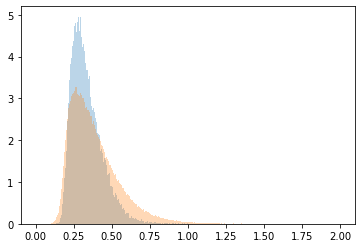

In [50]:
plt.hist(sigloss,bins=np.linspace(0,2,1001),alpha=0.3,density=True);
plt.hist(bkgloss,bins=np.linspace(0,2,1001),alpha=0.3,density=True);

In [24]:
inputlist = [
    '/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_BB1_rnd.h5',
    '/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_BB2.h5',
    '/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_BB3.h5',
    '/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_background.h5',
    '/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_rnd.h5',
    '/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_rnd.h5', 
    '/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_3prong_rnd.h5' 
]

In [25]:
ae_def

{'type': 'bkg',
 'trainon': 'purebkg',
 'features': '40part',
 'architecture': 'MAF',
 'selection': 'noselection',
 'trainloss': 'MSELoss',
 'beta': 'beta1',
 'zdimnflow': 'z10f10'}

In [26]:
outputlist_waic = [
    f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_WAICloss_bb1.npy",
    f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_WAICloss_bb2.npy",
    f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_WAICloss_bb3.npy",
    f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_WAICloss_purebkg.npy",
    f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_WAICloss_rndbkg.npy",
    f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_WAICloss_2prong.npy",
    f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_WAICloss_3prong.npy",
]

outputlist_justloss = [
    f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_Justloss_bb1.npy",
    f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_Justloss_bb2.npy",
    f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_Justloss_bb3.npy",
    f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_Justloss_purebkg.npy",
    f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_Justloss_rndbkg.npy",
    f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_Justloss_2prong.npy",
    f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_Justloss_3prong.npy",
]

In [27]:
exist_signalflag = [
    False,
    False,
    False,
    False,
    True,
    True,
    True,
]
is_signal = [
    False,
    False,
    False,
    False,
    False,
    True,
    True
]

nprong = [
    None,
    None,
    None,
    None,
    None,
    '2prong',
    '3prong'
]

In [68]:
for in_file, out_file_waic, out_file_justloss, sigbit_flag, is_sig, n_prong in zip(inputlist,outputlist_waic,outputlist_justloss,exist_signalflag,is_signal, nprong):    
    
    f_bb = pd.read_hdf(in_file)
    dt = f_bb.values
    correct = (dt[:,3]>0) &(dt[:,19]>0) & (dt[:,1]>0) & (dt[:,2]>0)
    dt = dt[correct]
    for i in range(13,19):
        dt[:,i] = dt[:,i]/dt[:,3]

    for i in range(29,35):
        dt[:,i] = dt[:,i]/(dt[:,19])



    if sigbit_flag:
        idx = dt[:,-1]
        sigidx = (idx == 1)
        bkgidx = (idx == 0)
        if is_sig:
            dt = dt[sigidx]
        else:
            dt = dt[bkgidx]
            
    if n_prong == '2prong':
        
        correct = (dt[:,3]>450) & (dt[:,3]<550) & (dt[:,19]>50) & (dt[:,19]<150) & (dt[:,0]>3400) & (dt[:,0]<3600)
        dt = dt[correct]
    
    if n_prong == '3prong':
        
        correct = (dt[:,3]>450) & (dt[:,3]<550) & (dt[:,19]>50) & (dt[:,19]<150) & (dt[:,0]>3400) & (dt[:,0]<3600)
        dt = dt[correct]  
            
    
    Y = dt[:,[4,5,6,7,8,11,12,13,14,15,16,17,18,20,21,22,23,24,27,28,29,30,31,32,33,34]]
    #Y = dt[:,[3,4,5,6,11,12,13,14,15,16,17,18,19,20,21,22,27,28,29,30,31,32,33,34]]
    #Y = dt[:,[3,4,5,6,11,12,13,14,15,16,17,18,19,20,21,22,27,28,29,30,31,32,33,34]]
    #Y = dt[:,[3,4,5,6,11,12,19,20,21,22,27,28]]
    

    
            
    print(Y.shape)
    for i in range(26):
        Y[:,i] = (Y[:,i]-bkg_mean[i])/bkg_std[i]
    
    total_bb_test = torch.tensor(Y)
    #huberloss = nn.SmoothL1Loss(reduction='none')
    sigae_bbloss = torch.mean((model(total_bb_test.float().cuda())[0]- total_bb_test.float().cuda())**2,dim=1).data.cpu().numpy()
    bbvar = torch.var((model(total_bb_test.float().cuda())[0]- total_bb_test.float().cuda())**2,dim=1).data.cpu().numpy()
    waic = sigae_bbloss + bbvar
    #sigae_bbloss = torch.mean(huberloss(model(total_bb_test.float().cuda())[0],total_bb_test.float().cuda()),dim=1).data.cpu().numpy()
    print(waic[0:10])
    plt.hist(waic,bins=np.linspace(0,10,1001),density=True);
    plt.xlim([0,2])
    np.save(out_file_waic,waic)
    np.save(out_file_justloss,sigae_bbloss)

(999728, 26)


RuntimeError: CUDA out of memory. Tried to allocate 100.00 MiB (GPU 0; 10.73 GiB total capacity; 9.74 GiB already allocated; 9.06 MiB free; 425.04 MiB cached)

In [166]:
f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_WAICloss_bb1.npy",
f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_WAICloss_bb2.npy",
f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_WAICloss_bb3.npy",
f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_WAICloss_purebkg.npy",
f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_WAICloss_rndbkg.npy",

('../data_strings/bkg_purebkg_cwola_mjj_mj1_mj2_cut_MSELoss_beta1_z8f8_WAICloss_rndbkg.npy',)

In [167]:
loss_prong3 = np.load(f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_Justloss_3prong.npy")
loss_prong2 = np.load(f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_Justloss_2prong.npy")
loss_purebkg = np.load(f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_Justloss_purebkg.npy")
loss_rndbkg = np.load(f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_Justloss_rndbkg.npy")



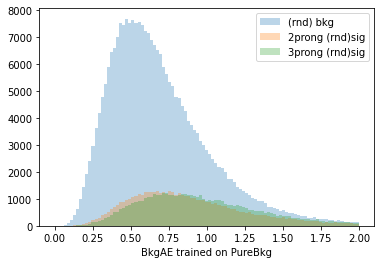

In [168]:
#plt.hist(loss_purebkg,bins=np.linspace(0,2,100),density=True,alpha=0.3,label='Pure Bkg');
plt.hist(loss_rndbkg,bins=np.linspace(0,2,100),density=False,alpha=0.3,label='(rnd) bkg');

plt.hist(loss_prong2,bins=np.linspace(0,2,100),density=False,alpha=0.3,label='2prong (rnd)sig');
plt.hist(loss_prong3,bins=np.linspace(0,2,100),density=False,alpha=0.3,label='3prong (rnd)sig');
#plt.yscale('log')
plt.xlabel('BkgAE trained on PureBkg')
plt.legend(loc='upper right')
#plt.savefig('bkgae_trained_on_purebkg_withmass_turnonselection.png')

In [169]:
ae_def

{'type': 'bkg',
 'trainon': 'purebkg',
 'features': 'cwola',
 'architecture': 'MAF',
 'selection': 'mjj_mj1_mj2_cut',
 'trainloss': 'MSELoss',
 'beta': 'beta1',
 'zdimnflow': 'z8f8'}

In [56]:
len(loss_prong2)

62906

In [50]:
def reconstruct(X):
    out = model(torch.tensor(X[:100000]).float().cuda())[0]
    out = out.data.cpu().numpy()
    return out

In [51]:
out = reconstruct(Y)

In [52]:
out.shape

(56525, 16)

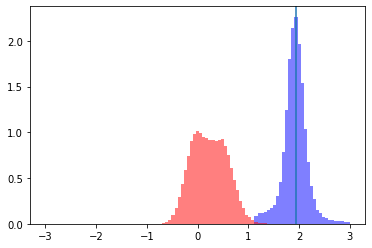

In [54]:
bins = np.linspace(-3,3,100)
bins.shape
column = 0
#print(df.coluns[column])
plt.hist(Y[:,column],bins,density=True,alpha=0.5,color='b');
plt.hist(out[:,column],bins,density=True,alpha=0.5,color='r');
plt.axvline(np.mean(Y[:,column]))

In [97]:
f_bb = pd.read_hdf('/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_3prong_rnd.h5')

In [98]:
dt = f_bb.values

In [99]:
correct = (dt[:,3]>0) &(dt[:,19]>0)
dt = dt[correct]
for i in range(13,19):
    dt[:,i] = dt[:,i]/dt[:,3]
    
for i in range(29,35):
    dt[:,i] = dt[:,i]/(dt[:,19])
        
        
correct = (dt[:,29]>=0) &(dt[:,29]<=1)&(dt[:,30]>=0) &(dt[:,30]<=1)&(dt[:,31]>=0) &(dt[:,31]<=1)&(dt[:,32]>=0) &(dt[:,32]<=1)&(dt[:,33]>=0) &(dt[:,33]<=1)&(dt[:,34]>=-0.01) &(dt[:,34]<=1)
dt = dt[correct]
Y = dt[:,[3,4,5,6,11,12,13,14,15,16,17,18,19,20,21,22,27,28,29,30,31,32,33,34]]

In [100]:
Y.shape

(78233, 24)

In [101]:
idx = dt[:,-1]
sigidx = idx == 1
bkgidx = idx == 0

In [108]:
for i in range(24):
    Y[:,i] = (Y[:,i]-bkg_mean[i])/bkg_std[i]

In [102]:
Y = Y[sigidx]

In [103]:
#correct = Y[:,0] > 300 #(For 2prong)
correct = Y[:,0] > 400 # (for 3prong)

In [104]:
Y = Y[correct]

In [105]:
Y.shape

(58822, 24)

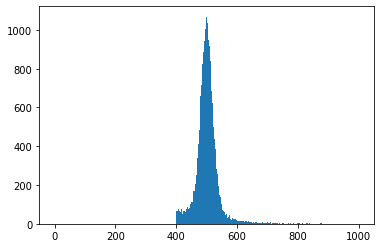

In [106]:
plt.hist(Y[:,0],bins=np.linspace(0,1000,1001));

In [109]:
np.mean(Y[:,0])

2.3954654567608404

In [110]:
total_bb_test = torch.tensor(Y)
bkgae_bbloss = torch.mean((model(total_bb_test.float().cuda())[0]- total_bb_test.float().cuda())**2,dim=1).data.cpu().numpy()

In [111]:
bkgae_bbloss

array([0.38415718, 0.4250854 , 0.79621285, ..., 0.53214365, 0.62708235,
       0.52163726], dtype=float32)

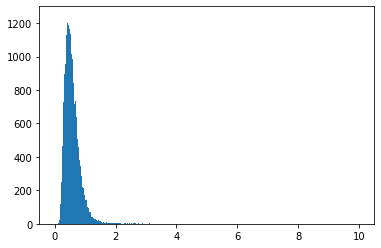

In [112]:
plt.hist(bkgae_bbloss,bins=np.linspace(0,10,1001));

In [113]:
np.save('../data_strings/bkgae_rndbkg_loss_3prong.npy',bkgae_bbloss)

In [52]:
loss_prong3 = np.load('../data_strings/bkgae_purebkg_loss_3prong.npy')
loss_prong2 = np.load('../data_strings/bkgae_purebkg_loss_2prong.npy')
loss_purebkg = np.load('../data_strings/bkgae_purebkg_loss_purebkg.npy')
loss_rndbkg = np.load('../data_strings/bkgae_purebkg_loss_rndbkg.npy')

In [162]:
len(loss_purebkg)

930647

In [117]:
len(loss_prong2)

57042

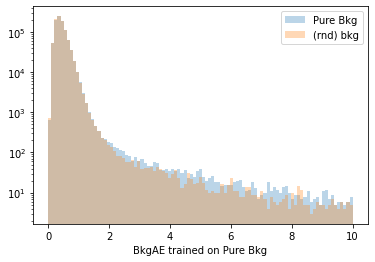

In [63]:
plt.hist(loss_purebkg,bins=np.linspace(0,10,100),weights=np.ones(len(loss_purebkg)),alpha=0.3,label='Pure Bkg');
plt.hist(loss_rndbkg,bins=np.linspace(0,10,100),weights=np.ones(len(loss_rndbkg))*(len(loss_purebkg)/len(loss_rndbkg)),alpha=0.3,label='(rnd) bkg');

#plt.hist(loss_prong3,bins=np.linspace(0,2,100),weights=np.ones(len(loss_prong3))*(len(loss_purebkg)/len(loss_prong3)),alpha=0.3,label='2prong (rnd)sig');
#plt.hist(loss_prong2,bins=np.linspace(0,2,100),weights=np.ones(len(loss_prong2))*(len(loss_purebkg)/len(loss_prong2)),alpha=0.3,label='3prong (rnd)sig');
plt.yscale('log')
plt.xlabel('BkgAE trained on Pure Bkg')
plt.legend(loc='upper right')
plt.savefig('bkgae_trained_on_pure_bkg_onlybkg.png')

In [97]:
def get_loss(dt):
    
    def generator(dt, chunk_size=5000, total_size=1000000):

        i = 0
        i_max = total_size // chunk_size
        print(i_max)
    
        for i in range(i_max):
            start=i * chunk_size
            stop=(i + 1) * chunk_size
            yield torch.tensor(dt[start:stop])
        
    loss = []

    
    with torch.no_grad():
        
        for total_in_selection in generator(dt,chunk_size=5000, total_size=1000000):
            loss.extend(torch.mean((model(total_in_selection.float().cuda())[0]- total_in_selection.float().cuda())**2,dim=1).data.cpu().numpy())
    
    return loss

In [98]:
bb1_loss_bkg = get_loss(X_bb1)

200


In [99]:
bb1_loss_bkg = np.array(bb1_loss_bkg,dtype=np.float)

In [100]:
bb1_loss_bkg

array([0.34203148, 0.20688626, 0.77139115, ..., 0.58295715, 0.60273141,
       0.670748  ])

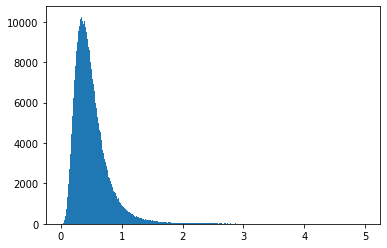

In [101]:
plt.hist(bb1_loss_bkg,bins=np.linspace(0,5,1001));

In [102]:
np.save('../data_strings/bkgaeloss_bb1.npy',bb1_loss_bkg)

In [103]:
f_bb2 = pd.read_hdf('/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_BB2.h5')
dt_bb2 = f_bb2.values

In [104]:
X_bb2 = dt_bb2[:,[3,4,5,6,11,12,19,20,21,22,27,28]]

In [105]:
for i in range(12):
    X_bb2[:,i] = (X_bb2[:,i]-bkg_mean[i])/bkg_std[i]

In [106]:
bb2_loss_bkg = get_loss(X_bb2)

200


In [107]:
bb2_loss_bkg = np.array(bb2_loss_bkg,dtype=np.float)

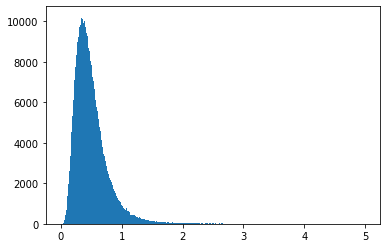

In [108]:
plt.hist(bb2_loss_bkg,bins=np.linspace(0,5,1001));

In [109]:
f_bb3 = pd.read_hdf('/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_BB3.h5')
dt_bb3 = f_bb3.values

In [110]:
X_bb3 = dt_bb3[:,[3,4,5,6,11,12,19,20,21,22,27,28]]

In [111]:
for i in range(12):
    X_bb3[:,i] = (X_bb3[:,i]-bkg_mean[i])/bkg_std[i]

In [137]:
bb3_loss_bkg = get_loss(X_bb3)

200


In [138]:
bb3_loss_bkg = np.array(bb3_loss_bkg,dtype=np.float)

In [139]:
bb3_loss_bkg

array([0.3940129 , 0.36679476, 0.56973112, ..., 0.26589143, 0.32429862,
       0.33480105])

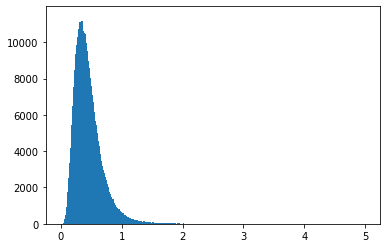

In [140]:
plt.hist(bb3_loss_bkg,bins=np.linspace(0,5,1001));

In [141]:
np.save('../data_strings/bkgaeloss_bb2.npy',bb2_loss_bkg)

In [142]:
np.save('../data_strings/bkgaeloss_bb3.npy',bb3_loss_bkg)

In [24]:
X[signal_idx].shape

(100000, 94)

In [72]:
loss_bkg = get_loss(X[bkg_idx])
loss_sig = get_loss(X[signal_idx])

(992924, 30)
(99829, 30)


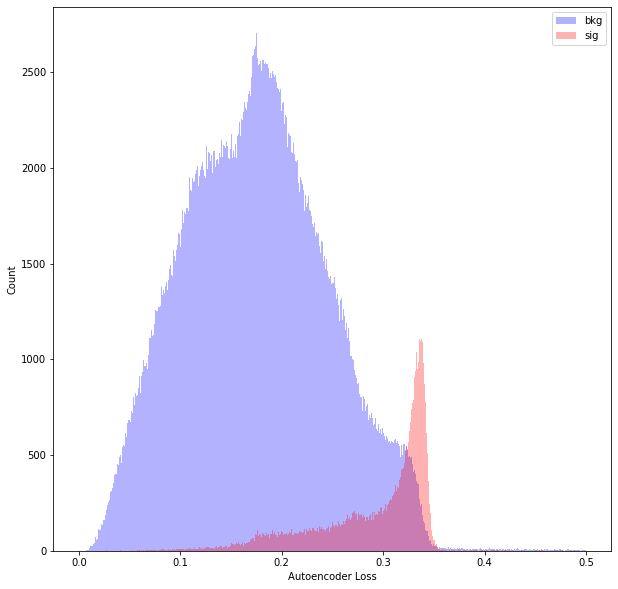

In [74]:
plt.rcParams["figure.figsize"] = (10,10)
bins = np.linspace(0,0.5,1100)
plt.hist(loss_bkg,bins=bins,alpha=0.3,color='b',label='bkg')
plt.hist(loss_sig,bins=bins,alpha=0.3,color='r',label='sig')
plt.xlabel(r'Autoencoder Loss')
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.show()

In [ ]:
def get_tpr_fpr(sigloss,bkgloss,aetype='sig'):
    bins = np.linspace(0,50,1001)
    tpr = []
    fpr = []
    for cut in bins:
        if aetype == 'sig':
            tpr.append(np.where(sigloss<cut)[0].shape[0]/len(sigloss))
            fpr.append(np.where(bkgloss<cut)[0].shape[0]/len(bkgloss))
        if aetype == 'bkg':
            tpr.append(np.where(sigloss>cut)[0].shape[0]/len(sigloss))
            fpr.append(np.where(bkgloss>cut)[0].shape[0]/len(bkgloss))
    return tpr,fpr        

In [ ]:
bkg_tpr, bkg_fpr = get_tpr_fpr(loss_sig,loss_bkg,aetype='bkg')

In [ ]:
np.save('NFLOWVAE_PlanarNEW_bkgAE_fpr.npy',bkg_fpr)
np.save('NFLOWVAE_PlanarNEW_bkgAE_tpr.npy',bkg_tpr)

In [ ]:
plt.plot(bkg_fpr,bkg_tpr,label='Bkg NFlowVAE-Planar')


In [ ]:
def get_precision_recall(sigloss,bkgloss,aetype='bkg'):
    bins = np.linspace(0,100,1001)
    tpr = []
    fpr = []
    precision = []
    for cut in bins:
        if aetype == 'sig':
            tpr.append(np.where(sigloss<cut)[0].shape[0]/len(sigloss))
            precision.append((np.where(sigloss<cut)[0].shape[0])/(np.where(bkgloss<cut)[0].shape[0]+np.where(sigloss<cut)[0].shape[0]))
            
        if aetype == 'bkg':
            tpr.append(np.where(sigloss>cut)[0].shape[0]/len(sigloss))
            precision.append((np.where(sigloss>cut)[0].shape[0])/(np.where(bkgloss>cut)[0].shape[0]+np.where(sigloss>cut)[0].shape[0]))
    return precision,tpr      

In [ ]:
precision,recall = get_precision_recall(loss_sig,loss_bkg,aetype='bkg')

In [ ]:
np.save('NFLOWVAE_PlanarNEW_22var_sigloss.npy',loss_sig)
np.save('NFLOWVAE_PlanarNEW_22var_bkgloss.npy',loss_bkg)

In [ ]:
np.save('NFLOWVAE_PlanarNEW_precision.npy',precision)
np.save('NFLOWVAE_PlanarNEW_recall.npy',recall)
np.save('NFLOWVAE_PlanarNEW_bkgAE_fpr.npy',bkg_fpr)
np.save('NFLOWVAE_PlanarNEW_bkgAE_tpr.npy',bkg_tpr)
np.save('NFLOWVAE_PlanarNEW_sigloss.npy',loss_sig)
np.save('NFLOWVAE_PlanarNEW_bkgloss.npy',loss_bkg)

In [ ]:
plt.plot(recall,precision)

In [ ]:
flows = [1,2,3,4,5,6]
zdim = [1,2,3,4,5]

for N_flows in flows:
    for Z_DIM in zdim:
        model = VAE_NF(N_FLOWS, Z_DIM).cuda()
        optimizer = optim.Adam(model.parameters(), lr=LR)
        BEST_LOSS = 99999
        LAST_SAVED = -1
        PATIENCE_COUNT = 0
        PATIENCE_LIMIT = 5
        for epoch in range(1, N_EPOCHS):
            print("Epoch {}:".format(epoch))
            train()
            cur_loss = evaluate()

            if cur_loss <= BEST_LOSS:
                PATIENCE_COUNT = 0
                BEST_LOSS = cur_loss
                LAST_SAVED = epoch
                print("Saving model!")
                if mode == 'ROC':
                    torch.save(model.state_dict(),f"/data/t3home000/spark/QUASAR/weights/bkg_vae_NF_planar_RND_22var_z{Z_DIM}_f{N_FLOWS}.h5")
                else:
                    torch.save(model.state_dict(), f"/data/t3home000/spark/QUASAR/weights/bkg_vae_NF_planar_PureBkg_22var_z{Z_DIM}_f{N_FLOWS}.h5")
            else:
                PATIENCE_COUNT += 1
                print("Not saving model! Last saved: {}".format(LAST_SAVED))
                if PATIENCE_COUNT > 3:
                    print("Patience Limit Reached")
                    break 
                    
        loss_bkg = get_loss(dt_PureBkg[bkg_idx])
        loss_sig = get_loss(dt_PureBkg[signal_idx])
        np.save(f'NFLOWVAE_PlanarNEW_22var_z{Z_DIM}_f{N_flows}_sigloss.npy',loss_sig)
        np.save(f'NFLOWVAE_PlanarNEW_22var_z{Z_DIM}_f{N_flows}_bkgloss.npy',loss_bkg)